## Goal

Using 300deg data set, using the same profile position, we will compare the y-center found by the fitting for different profile width. This will allow to check the accuracy of the fitting method to determine the beam center.

width tested are 1, 3, 5, 7, 9 and 11 pixels wide. 


This notebooks takes the profile files produced by the [profile](https://neutronimaging.ornl.gov/tutorials/imaging-notebooks/profile/linear-profile/) notebook.

<img src='static/screenshot_of_profile_file.png' />


In [5]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob
import pprint

import matplotlib.pyplot as plt
%matplotlib notebook

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*base_folder = "/SNS/VENUS/IPTS-31716/shared/NC_images/2023-06-12"*


# User input 

In [6]:
top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"
# top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"

### setup base folder 

In [7]:
base_folder = top_folder + "/profiles/"
assert os.path.exists(base_folder)  # making sure the base folder exists

## listing the profiles for 300deg image with various profile width

In [8]:
list_profile_files = glob.glob(os.path.join(base_folder, '300deg_various_width_profiles') + '/*.txt')
assert len(list_profile_files) > 0

In [9]:
# pprint.pprint(f"{list_profile_files =}")

## loading the profiles via pandas 

In [10]:
def extract_width_value(file_name):
    base_name = os.path.basename(file_name)
    base, ext = os.path.splitext(base_name)
    split_base_name = base.split("_")
    return split_base_name[-1]

In [11]:
master_dict = {'yaxis': None,
              'profile': {}}

for _index, _file in enumerate(list_profile_files):
    pd_data = pd.read_csv(_file, skiprows=8)
    list_names_of_columns = list(pd_data.columns)
    
    if _index == 0:
        yaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
        master_dict['yaxis'] = yaxis
        
    profile = np.asarray(pd_data.loc[:, list_names_of_columns[-1]])
    key = extract_width_value(_file)
    master_dict['profile'][key] = profile

In [13]:
# master_dict

## fitting and calculation of center 

In [14]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

master_fitting_dic = {}
xaxis = master_dict['yaxis']
for _key in master_dict['profile'].keys():
    
    yaxis = master_dict['profile'][_key]
    
    pars = mod.make_params(c=yaxis.mean(),
                           center=3000,
                           sigma=xaxis.std(),
                           amplitude=xaxis.std() * yaxis.ptp())

    out = mod.fit(yaxis, pars, x=xaxis)
        
    master_fitting_dic[_key] = {'center_y_value': round(out.params['center'].value),
                                'center_y_error': out.params['center'].stderr,
                                'fitting': out.best_fit,
                               }
    


## let's compare the center versus the width of the profile 

<IPython.core.display.Javascript object>


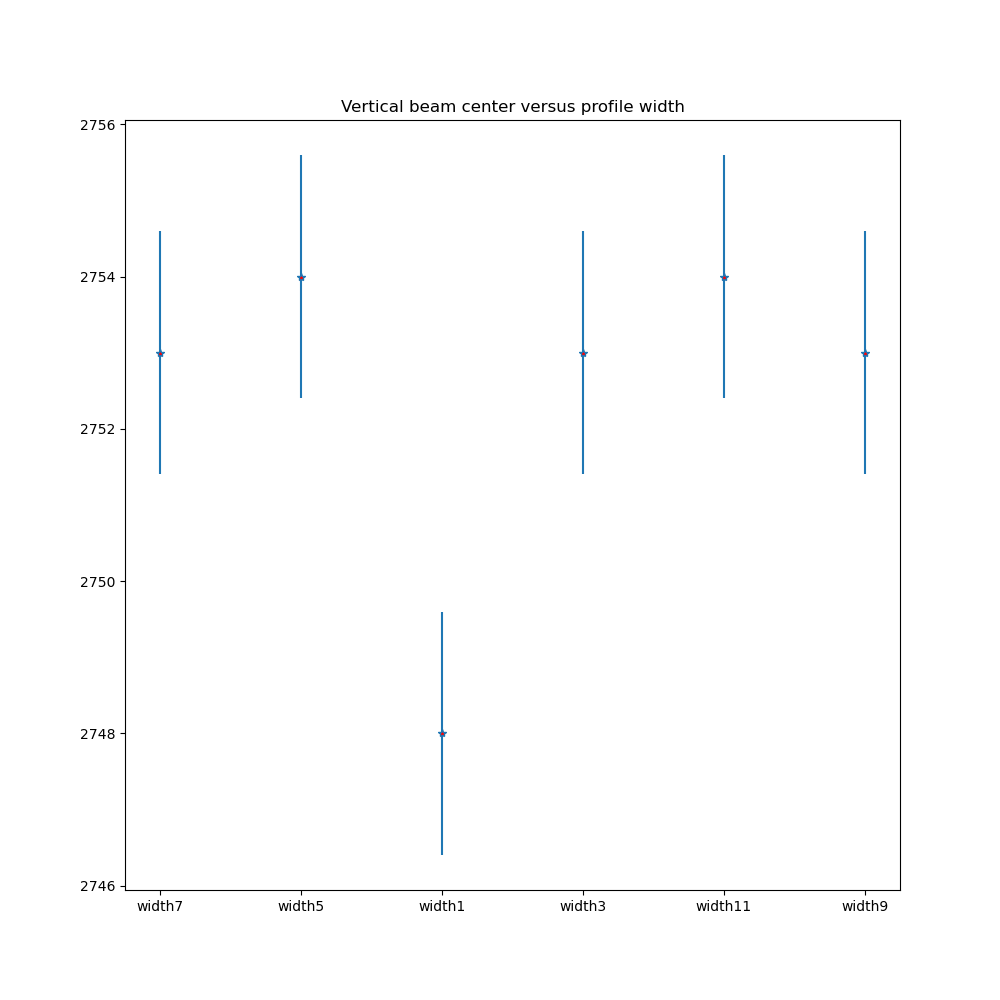

([<matplotlib.axis.XTick at 0x7fadd9003880>,
 [Text(0, 0, 'width7'),
  Text(1, 0, 'width5'),
  Text(2, 0, 'width1'),
  Text(3, 0, 'width3'),
  Text(4, 0, 'width11'),
  Text(5, 0, 'width9')])

In [15]:
plt.figure(figsize=(10, 10))
plt.title("Vertical beam center versus profile width")

xaxis = np.arange(len(master_fitting_dic.keys()))
yaxis = []
xlabels = []
for _key in master_fitting_dic.keys():
    
    yerror = []
    
    yaxis.append(master_fitting_dic[_key]['center_y_value'])
    yerror.append(master_fitting_dic[_key]['center_y_error'])
    xlabels.append(_key)

plt.errorbar(xaxis, yaxis, yerr=yerror, linestyle='None', marker='*', markerfacecolor='r')
plt.xticks(xaxis, xlabels)    

## conclusion

This shows that 3 pixels wide is probably the best width of the profile to use but in any case 1 pixel should be selected. 